This notebook addresses a flexible resource constrained parallel machine scheduling problem. The objective studied is minimizing the number tardy jobs.

The Flexible Resource Constrained Scheduling Problem (FRCSP) is an extension of resource constrained scheduling problem which allows a job operation to be processed by any of available resource from a given resource set. In our example, each job is associated with a set of operation types which need to be processed in a specific order (known as precedence constraints). There is a set of alternative operations with associated type, duration, and capacity. Each operation also requires a set of resources with limited capacity. 

This problem is known to be NP-hard. IBM ILOG CPLEX Optimization Studio includes solvers for both Mathematical and Constraint Programming. Constraint Programming is particularly efficient and useful to tackle detailed scheduling problems. By using docplex.cp python package, you can easily formulate and solve scheduling problems in python notebooks. Below is an example formulation with randomly generated sample data to provide a better understanding of the problem and the model.

In [1]:
#randomly generate set of jobs with an associated due date 
nbrOfJobs = 10
jobs = [*range(0, nbrOfJobs)] 
minDueDate=2000
maxDueDate=3000
import random
dueDates = [random.randint(minDueDate,maxDueDate) for j in jobs] 

In [2]:
#randomly generate set of operations with an associated operation type, duration and capacity
import pandas as pd
nbrOfOpsTypes = 5
opstypes= [*range(0, nbrOfOpsTypes)] 
minDuration=10
maxDuration=40
durations= [random.randint(minDuration,maxDuration) for ot in opstypes] 
nbrOfOps = 20
ops = [*range(0, nbrOfOps)] 
OperationsTable = pd.DataFrame(columns=['op_id', 'op_type', 'duration', 'capacity'])
for o in ops:
    otype=random.randint(0,nbrOfOpsTypes-1)
    OperationsTable=OperationsTable.append({'op_id': o,'op_type':otype,'duration':durations[otype],'capacity':random.randint(2,5)}, ignore_index=True)
from collections import namedtuple
TOperations = namedtuple("TJobsOperations", ['op_id', 'op_type', 'duration', 'capacity'])
Operations = [TOperations(*operations_row) for operations_row in OperationsTable.itertuples(index=False)]
print(OperationsTable)

   op_id op_type duration capacity
0      0       4       31        2
1      1       2       10        2
2      2       0       34        2
3      3       4       31        3
4      4       3       12        4
5      5       3       12        5
6      6       0       34        2
7      7       4       31        4
8      8       2       10        3
9      9       0       34        5
10    10       1       38        5
11    11       2       10        2
12    12       2       10        4
13    13       3       12        5
14    14       4       31        5
15    15       4       31        5
16    16       4       31        3
17    17       2       10        2
18    18       4       31        2
19    19       4       31        5


In [3]:
#randomly generate operation types required by each job
required_op_types=[sorted(random.sample(range(0, nbrOfOpsTypes), random.randint(nbrOfOpsTypes-3,nbrOfOpsTypes))) for j in jobs]
print(required_op_types)   

[[0, 2, 4], [0, 2, 3, 4], [0, 1, 2, 3, 4], [2, 4], [0, 1, 2, 3, 4], [0, 2, 4], [0, 4], [2, 3], [0, 1, 2, 4], [0, 1, 2, 4]]


In [4]:
#randomly generate a set of resources with an associated capacity
nbrOfResources = 3
resources = [*range(0, nbrOfResources)] 
print(resources)
resourceCapacities= [random.randint(20,32) for r in resources]
print(resourceCapacities)

[0, 1, 2]
[32, 23, 23]


In [5]:
#randomly generate resources required by each operation
resourceDemand = [[random.randint(0,4) for r in resources]  for o in ops] 
print(resourceDemand)  # resourceDemand_list[o][r]

[[1, 0, 3], [3, 4, 2], [1, 4, 2], [3, 3, 4], [1, 4, 1], [1, 4, 0], [4, 2, 2], [1, 1, 2], [0, 0, 1], [1, 1, 1], [4, 2, 2], [2, 1, 0], [1, 4, 0], [4, 2, 4], [1, 4, 0], [3, 1, 0], [0, 0, 2], [3, 1, 3], [4, 2, 4], [2, 4, 2]]


In [6]:
from docplex.cp.model import *
mdl = CpoModel(name='parallelMachine_FlexibleRSCP') 

In [7]:
# Create optional interval variables for each operation 
ops_itv_vars = {}
for o in Operations:
    ops_itv_vars[(o.op_id)] = mdl.interval_var(optional=True, name="Opr{}".format(o.op_id), size=o.duration) 

In [8]:
# Create binary variables for tardy jobs --- 1 if job cannot complete all required operations on-time, 0 otherwise
tardy_jobs_vars = mdl.binary_var_dict(jobs, name="isTardy") 

In [9]:
# Create job-operation interval and assignment variables
jobops_itv_vars = {}
for j in jobs:
    for o in Operations:
        jobops_itv_vars[(j,o.op_id)] = mdl.interval_var(optional=True, name="Job{}Opr{}".format(j,o.op_id), size=o.duration)

In [10]:
# Maximize jobs completed on-time - Minimize number of tardy jobs
objective = mdl.sum(tardy_jobs_vars[(j)] for j in jobs)
mdl.add(mdl.minimize(objective)) 

In [11]:
# Capacity of resources cannot be exceeded
for r in range(nbrOfResources):
    resources = [mdl.pulse(ops_itv_vars[(o.op_id)], resourceDemand[(o.op_id)][r]) for o in Operations if resourceDemand[(o.op_id)][r] > 0]  
    mdl.add(mdl.sum(resources) <= resourceCapacities[r])

In [12]:
# Capacity of operations (batching) cannot be exceeded
for o in Operations:
    mdl.add(mdl.sum(mdl.presence_of(jobops_itv_vars[(j,o.op_id)]) for j in jobs) <= o.capacity)

In [13]:
# ensure that if a job is assigned to an operation then operation should be performed
for j in jobs:
    for o in Operations:
        mdl.add(mdl.synchronize(jobops_itv_vars[(j,o.op_id)], [ops_itv_vars[(o1.op_id)] for o1 in Operations if o1==o]))

for j in jobs:
    for o in Operations:
        mdl.add(mdl.presence_of(jobops_itv_vars[(j,o.op_id)])<= mdl.presence_of(ops_itv_vars[(o.op_id)]))

In [14]:
#define tardy jobs
for j in jobs:
    for o in Operations:
        mdl.add((mdl.end_of(jobops_itv_vars[(j,o.op_id)])-dueDates[j])<=999*tardy_jobs_vars[j])   

In [15]:
# on-time jobs should be assigned to all required op types 
for j in jobs:
    for ot in opstypes:
        if ot in required_op_types[(j)]:
            mdl.add((1-tardy_jobs_vars[(j)]) == mdl.sum(mdl.presence_of(jobops_itv_vars[(j,o.op_id)]) for o in Operations if o.op_type==ot))
        if ot not in required_op_types[(j)]: # added to avoid unnecessary assignments
            mdl.add(0 == mdl.sum(mdl.presence_of(jobops_itv_vars[(j,o.op_id)]) for o in Operations if o.op_type==ot))

In [16]:
#no overlap
for j in jobs:
        mdl.add(mdl.no_overlap(jobops_itv_vars[(j,o.op_id)] for o in Operations))

In [17]:
# Add precedence constraints
for j in jobs:
    for o1 in Operations:
        for o2 in Operations:
            if o1<o2:
                mdl.add(mdl.end_before_start(jobops_itv_vars[(j,o1.op_id)], jobops_itv_vars[(j,o2.op_id)]))

In [18]:
msol= mdl.solve(log_output=True)

In [19]:
print("Solution: ")
msol.print_solution()

Solution: 
-------------------------------------------------------------------------------
Model constraints: 2583, variables: integer: 10, interval: 220, sequence: 10
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 2.86 sec
-------------------------------------------------------------------------------
Objective values: (0,), bounds: (0,), gaps: (0,)
isTardy_0=0
isTardy_1=0
isTardy_2=0
isTardy_3=0
isTardy_4=0
isTardy_5=0
isTardy_6=0
isTardy_7=0
isTardy_8=0
isTardy_9=0
Job0Opr0: absent
Job0Opr1: absent
Job0Opr2: absent
Job0Opr3: absent
Job0Opr4: absent
Job0Opr5: absent
Job0Opr6: (start=0, end=34, size=34, length=34)
Job0Opr7: absent
Job0Opr8: absent
Job0Opr9: absent
Job0Opr10: absent
Job0Opr11: absent
Job0Opr12: (start=82, end=92, size=10, length=10)
Job0Opr13: absent
Job0Opr14: absent
Job0Opr15: absent
Job0Opr16: absent
Job0Opr17: absent
Job0Opr18: absent
Job0Opr19: (start=492, end=523, size=31

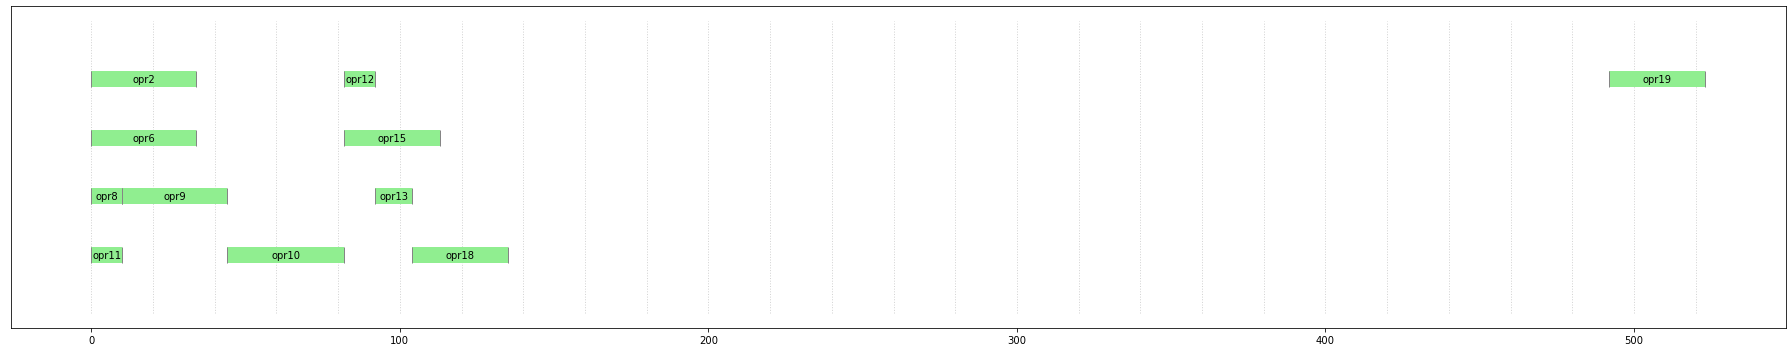

In [20]:
# Solve model
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 25, 5

if msol and visu.is_visu_enabled():
    visu.timeline("Solution Schedule", 0, 100)
    for o in Operations:
        itv = msol.get_var_solution(ops_itv_vars[(o.op_id)])
        if itv.is_present():
            visu.interval(itv,'lightgreen','opr' + str(o.op_id))
    visu.show()